In [ ]:
#Necessary imports 

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision

device = torch.device("cuda")


import zipfile
import os
import gdown
import torch
from natsort import natsorted
from PIL import Image
import pickle

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torchvision import transforms

from google.colab import drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


cuda


In [ ]:
#Load the data


data = np.load("./gdrive/MyDrive/Colab Notebooks/data20k.npy")
dataset_t = torch.from_numpy(data)
dataset_t.shape
data = DataLoader(dataset_t, batch_size=256)

In [ ]:
#Analytical solution to KL divergence
def normal_kl(mu, logvar):
    
    kl = -0.5 * (-mu.pow(2) - logvar.exp() + logvar + 1)

    return kl.sum(1).mean(0)

#The reparametrization trick
def reparameter(dist, latent):
        mu = dist[:,latent:]
        
        logvar = dist[:, :latent]
        
        std = logvar.div(2).exp()
        eps = std.data.new(std.size()).normal_()
        
        return eps.mul(std).add_(mu), mu, logvar

#Helper function to print layers
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

#Helper function for Mean Squared Error
def loss_function(x, X):

    return nn.functional.mse_loss(x,X)
    
#Model
class CNN(nn.Module):
    def __init__(self, latent,beta, Wbeta):
        super(CNN, self).__init__()
        
        self.latent = latent
        self.beta = beta
        self.Wbeta = Wbeta
        
        #Encoder Layer (5xConvolutional layer  with Batch-normalization for stability and LeakyRelu activation)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, out_channels=32, kernel_size= 4, stride= 2, padding  = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Conv2d(32, out_channels=64, kernel_size= 4, stride= 2, padding  = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            nn.Conv2d(64, out_channels= 128, kernel_size= 4, stride= 2, padding  = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            
            nn.Conv2d(128, out_channels=256, kernel_size= 4, stride= 2, padding  = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.Conv2d(256, out_channels=256, kernel_size= 4, stride= 2, padding  = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
                    
        )
        
        #Last layer of the encoder (Conv to dense)
        self.encoder_l = nn.Linear(256*2*2, self.latent*2)
        
        #First leyer of the decoder (dense to Conv)
        self.decoder_f =nn.Linear(self.latent, 256*2*2)

        #Decoder Layer (5 Deconv Layers with Batch-normalization for stability and LeakyRelu activation)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, out_channels=256, kernel_size= 4, stride= 2, padding  = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, out_channels=128, kernel_size= 4, stride= 2, padding  = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(128, out_channels= 64, kernel_size= 4, stride= 2, padding  = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(64, out_channels=32, kernel_size= 4, stride= 2, padding  = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(32, out_channels=32, kernel_size= 4, stride= 2, padding  = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.Conv2d(32, out_channels=3, kernel_size= 3, padding  = 1),
            nn.Tanh()
        )
        
    #Wrapper function for forward pass
    def forward(self, x):
        b_size = x.shape[0]
        
        #Encoder layers
        out = self.encoder(x)
        out = out.view(b_size,-1)
        out = self.encoder_l(out)
        
        #Reparametrization trick (return log(var) for stability)
        #Converted to exp(log(var)) in the loss function
        reparam, mu, logvar = reparameter(out, self.latent)
        
        #Decoder layers
        out = self.decoder_f(reparam)
        out = out.view(b_size,256,2,2)
        out = self.decoder(out)
        #print(out.shape)
        

        return out, mu, logvar
    
    #Initializing weights of the model with std. normal (emprically faster convergence than uniform initialization)
    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                if isinstance(m, (nn.Linear)) or True:
                    init.kaiming_normal(m.weight)
                    if m.bias is not None:
                        m.bias.data.fill(0)
        
    
        
        

    
#Train loop
def train(dataloader, model, loss_fn, optimizer,beta, Wbeta):
    model.train()
    tsize = 0
    loss_sum = 0
    kl_sum = 0
    bkl_sum = 0

    #For every batch
    for batch, X in enumerate(dataloader):
        if batch==0:
            print("BEGIN")
        # Compute prediction and loss
        batch_size = X.shape[0]
        
        #Calculate the forward pass
        X = X.float().to(device)
        x_pred, mu, logvar = model(X)
        
        #MSE loss
        loss = loss_fn(x_pred,X)
        #KL loss
        kl = normal_kl(mu, logvar)
        
        #Calculate MSE + Beta*KL
        tloss = loss+ Wbeta * beta*kl
        

        
        loss_sum += loss.item()
        kl_sum += kl.item()
        bkl_sum += Wbeta * beta * kl.item()
        tsize += 1
        # Backpropagation
        optimizer.zero_grad()
        tloss.backward()
        optimizer.step()

        if batch % 10 == 0 and False:
            loss, tloss, current = loss.item(), tloss.item(), batch * len(X)
            print("",end="\r")
            print(f"loss: {tloss:>7f} - kl:{kl.item():>7f} - bkl:{kl.item()*self.beta:>7f} [{current:>5d}/{len(dataloader.dataset):>5d}]", end="")
    tloss_s = (loss_sum+bkl_sum)/tsize
    #print("", end="\r")
    print(f"loss: {(tloss_s):>7f} - kl:{(kl_sum/tsize):>7f} -  bkl:{bkl_sum/tsize:>7f} - loss:{(loss_sum/tsize)} ")
    return tloss_s, (kl_sum/tsize) , bkl_sum/tsize, loss_sum/tsize



In [ ]:
#Code to import checkpoint


#device = torch.device("cuda")
checkpoint = torch.load("/content/gdrive/My Drive/Colab Notebooks/checkpoint_7.pth", map_location=device)
model = checkpoint['model']
loss_fn = loss_function
optimizer = checkpoint['optimizer']
scheduler = checkpoint['scheduler']
t = checkpoint['epoch']
[tloss_s, kl_sum , bkl_sum, loss_sum, beta, beta_norm, beta_scale] = checkpoint['vars']


In [ ]:
#A scaling for beta, that increases beta every so often, in order to prevent posterior collapse
def beta_scale_f(t):
    return (1/(1+np.exp(-((t+1)/25))))*2 -1

print(beta_scale_f(0))

0.01999733375993107


In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
"""
device = torch.device("cuda")
#device = torch.device("cpu")


learning_rate = 0.001
epochs = 5000
beta = 0.01
latent = 128
im_size = 64*64
decayRate = 0.5
beta_scale = beta_scale_f(0)
t = 0

beta_norm = beta *(latent/(im_size))


model = CNN(latent=latent, beta=beta_norm, Wbeta = beta_scale).to(device)
loss_fn = loss_function
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1)
"""
"""
checkpoint = torch.load("/content/gdrive/My Drive/Colab Notebooks/checkpoint_3.pth", map_location=device)
model = checkpoint['model']
loss_fn = loss_function
optimizer = checkpoint['optimizer']
scheduler = checkpoint['scheduler']
t = checpoint['epoch']
[tloss_s, kl_sum , bkl_sum, loss_sum, beta, beta_norm, beta_scale] = checkpoint['vars']
"""
for g in optimizer.param_groups:
    g['lr'] = 0.01

scheduler2 =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor = 0.5, threshold=0.001,min_lr=0.0001)

#For 5000 Epochs
while t < 5000:
    print()
    print(f"Epoch {t} | Wb: {beta_scale}  | Lr: {get_lr(optimizer)}\n-------------------------------")
    
    #After 100th epoch, update beta_scaling parameter every 5th epoch
    if (t>100) and beta_scale < 1 and t%5 == 0:
        beta_scale = min(beta_scale_f(t-100),1)
        if beta_scale > 0.96:
            beta_scale = 1.

    
    model.Wbeta = beta_scale
    tloss_s, kl_sum , bkl_sum, loss_sum = train(data, model, loss_fn, optimizer, beta = beta_norm, Wbeta = beta_scale)

    #If beta_scaling is being updated, then don't change the learning rate (Loss will increase due to increasing beta)
    if t == 290 or t == (290+50):
        scheduler.step()
    scheduler2.step(tloss_s)

    #Save model every 30 epoch
    if t%30 ==0 and t!=0:
        checkpoint = { 
            'vars' : [tloss_s, kl_sum , bkl_sum, loss_sum, beta, beta_norm, beta_scale],
            'epoch': t,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, "/content/gdrive/My Drive/Colab Notebooks/checkpoint_7.pth")
    t = t+1

print("Done!")


Epoch 480 | Wb: 1.0  | Lr: 0.01
-------------------------------
BEGIN
loss: 0.061846 - kl:61.236740 -  bkl:0.019136 - loss:0.04270965393774117 

Epoch 481 | Wb: 1.0  | Lr: 0.01
-------------------------------
BEGIN
loss: 0.061556 - kl:61.107319 -  bkl:0.019096 - loss:0.042460110179985626 

Epoch 482 | Wb: 1.0  | Lr: 0.01
-------------------------------
BEGIN
loss: 0.061485 - kl:61.200804 -  bkl:0.019125 - loss:0.04235948103515408 

Epoch 483 | Wb: 1.0  | Lr: 0.01
-------------------------------
BEGIN
loss: 0.061333 - kl:61.137495 -  bkl:0.019105 - loss:0.042227740482061724 

Epoch 484 | Wb: 1.0  | Lr: 0.01
-------------------------------
BEGIN
loss: 0.061290 - kl:61.078195 -  bkl:0.019087 - loss:0.042203092593935475 

Epoch 485 | Wb: 1.0  | Lr: 0.01
-------------------------------
BEGIN
loss: 0.061265 - kl:61.112434 -  bkl:0.019098 - loss:0.0421678380969959 

Epoch 486 | Wb: 1.0  | Lr: 0.01
-------------------------------
BEGIN
loss: 0.061208 - kl:61.144892 -  bkl:0.019108 - loss:0.04

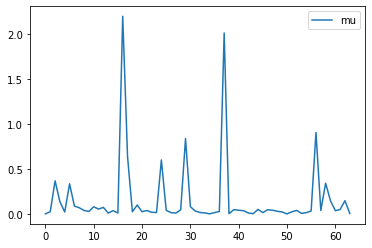

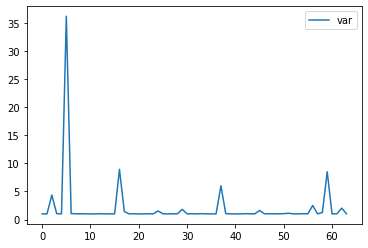

(64, 64, 3)


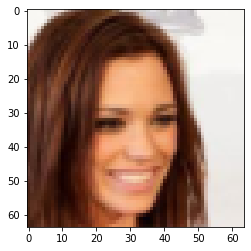

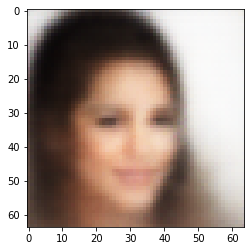

In [ ]:
#Code to get a random data, and do forward pass
#Plot the latent variables (mu and sigma), plot the original data and reconstruction

device = torch.device("cpu")
k = data.dataset[np.random.randint(len(data.dataset))].view(1,3,64,64)


out = model.encoder(k.to(device).float())
out = out.view(1,-1)
out = model.encoder_l(out)


reparam, mu, logvar = reparameter(out, model.latent)




rep,mu,logvar = reparameter(out,model.latent)



out = model.decoder_f(rep)
out = out.view(-1,256,2,2)
out = model.decoder(out)

mu = np.abs(mu.detach().cpu().numpy())
logvar = np.abs(logvar.detach().cpu().numpy())
#rep = np.abs(rep.detach().cpu().numpy())


plt.plot(mu.T, label="mu")
plt.legend()
plt.show()
plt.plot(np.exp(logvar.T), label="var")
plt.legend()
plt.show()
#plt.plot(rep[0], label="rep")



k_np = k[0].permute(1,2,0).numpy()
k_np = np.interp(k_np, (-1,+1), (0, 1))

print(k_np.shape)

out_np = out.cpu().detach()[0].permute(1,2,0).numpy()
out_np = np.interp(out_np, (-1,1), (0,1))

plt.imshow(k_np, cmap=plt.cm.gray)
plt.show()
plt.imshow(out_np, cmap=plt.cm.gray)
plt.show()




0
10


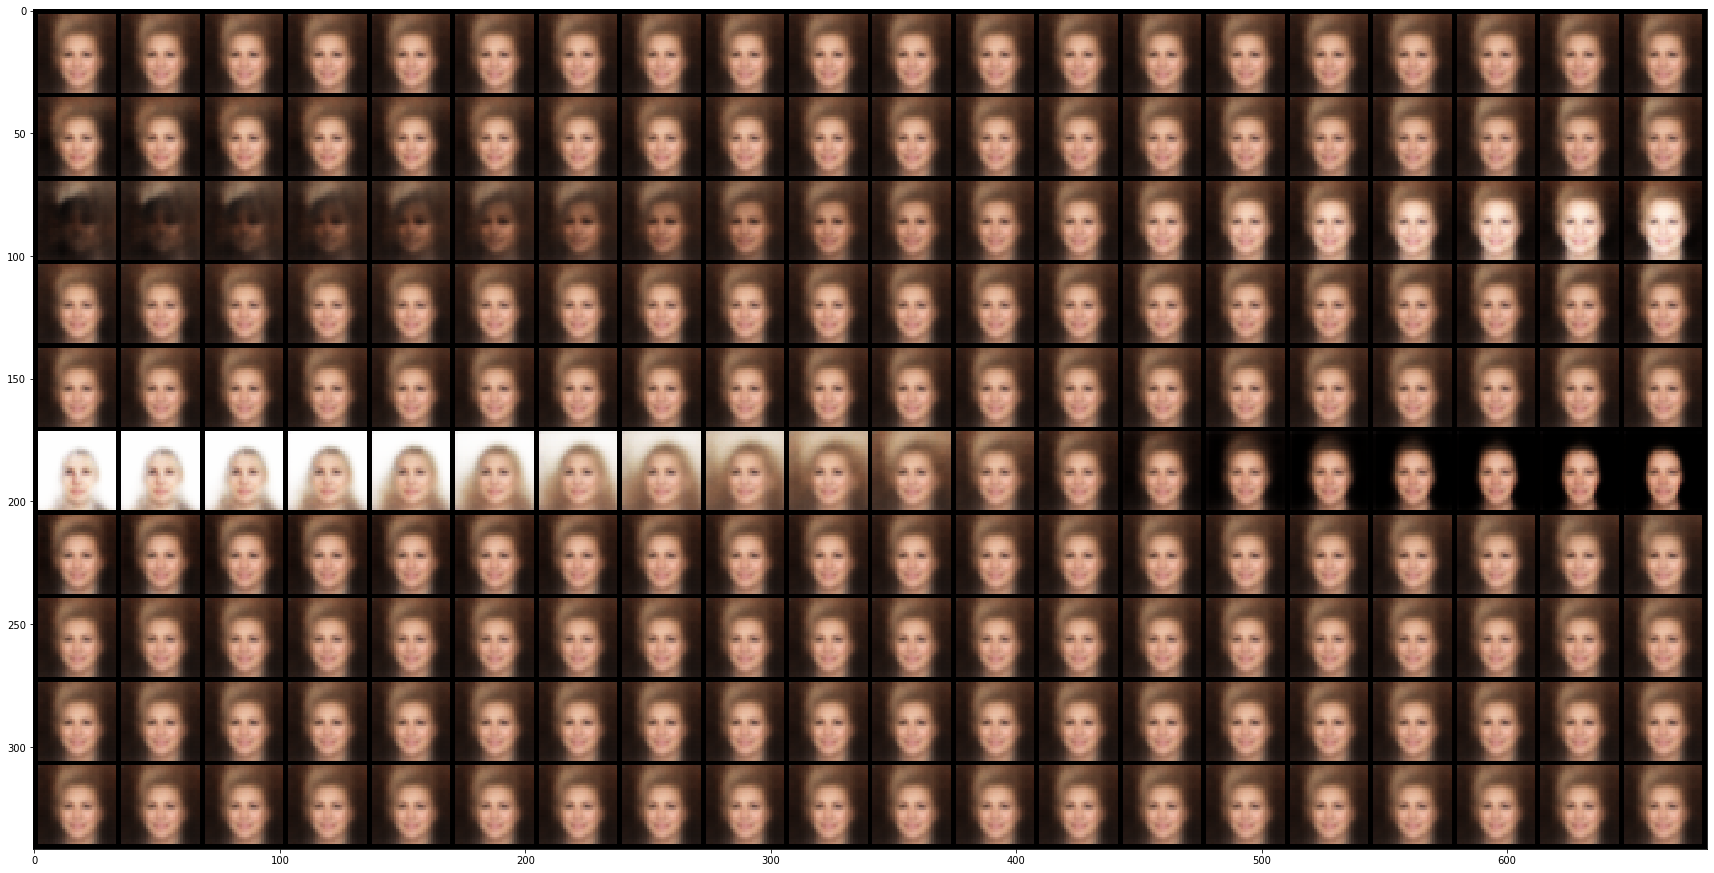

10
20


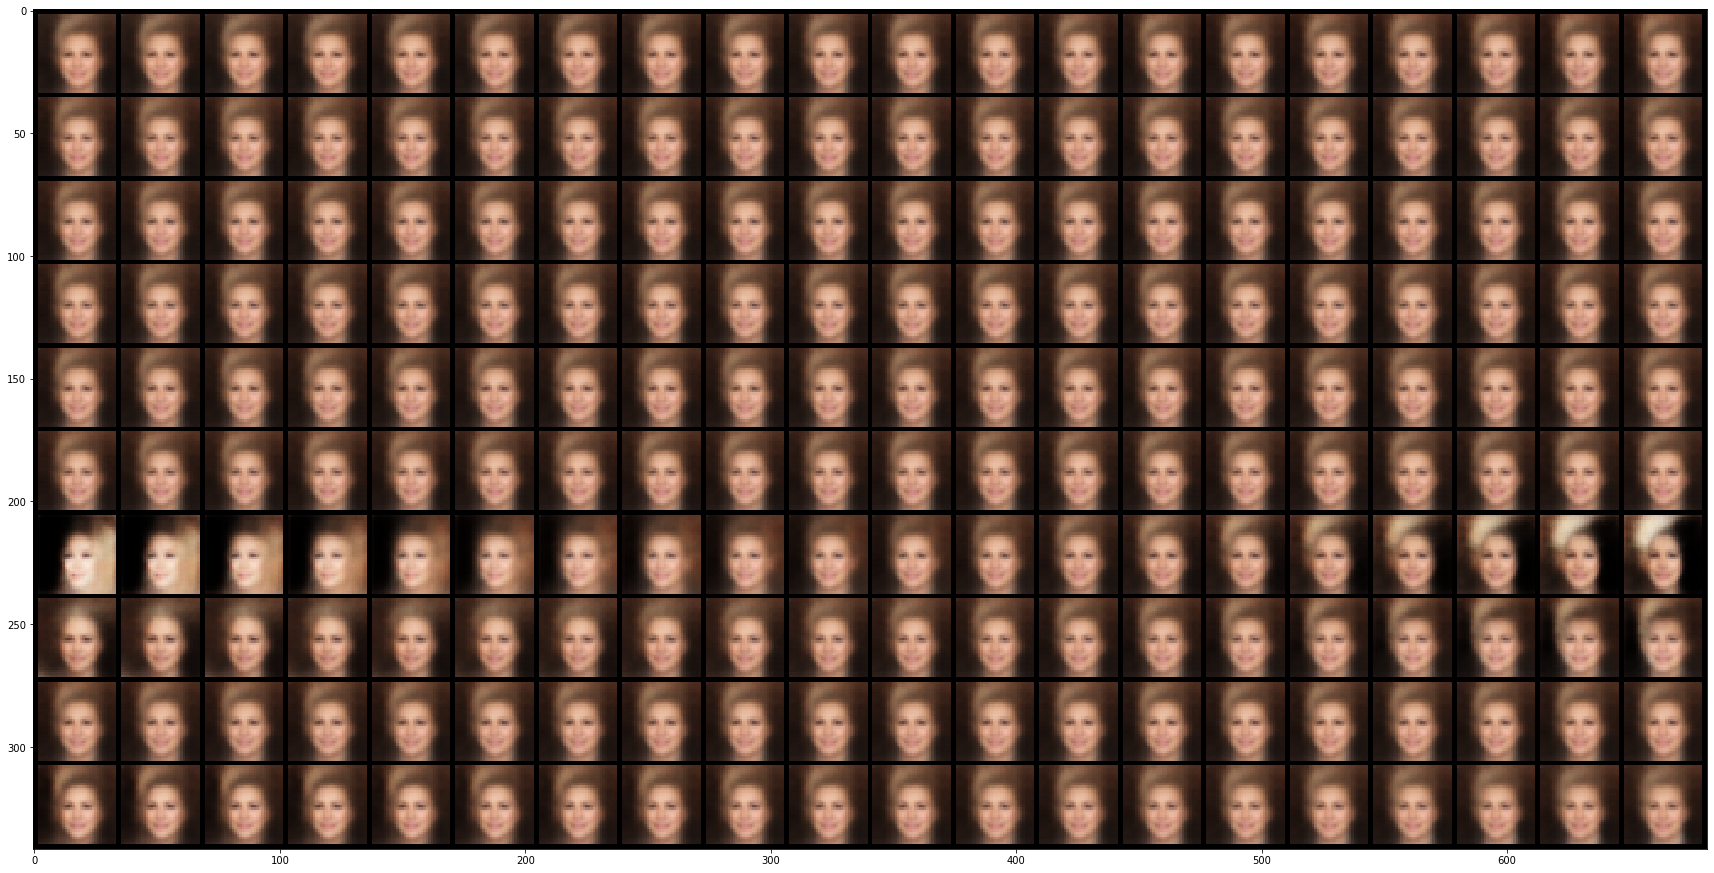

20
30


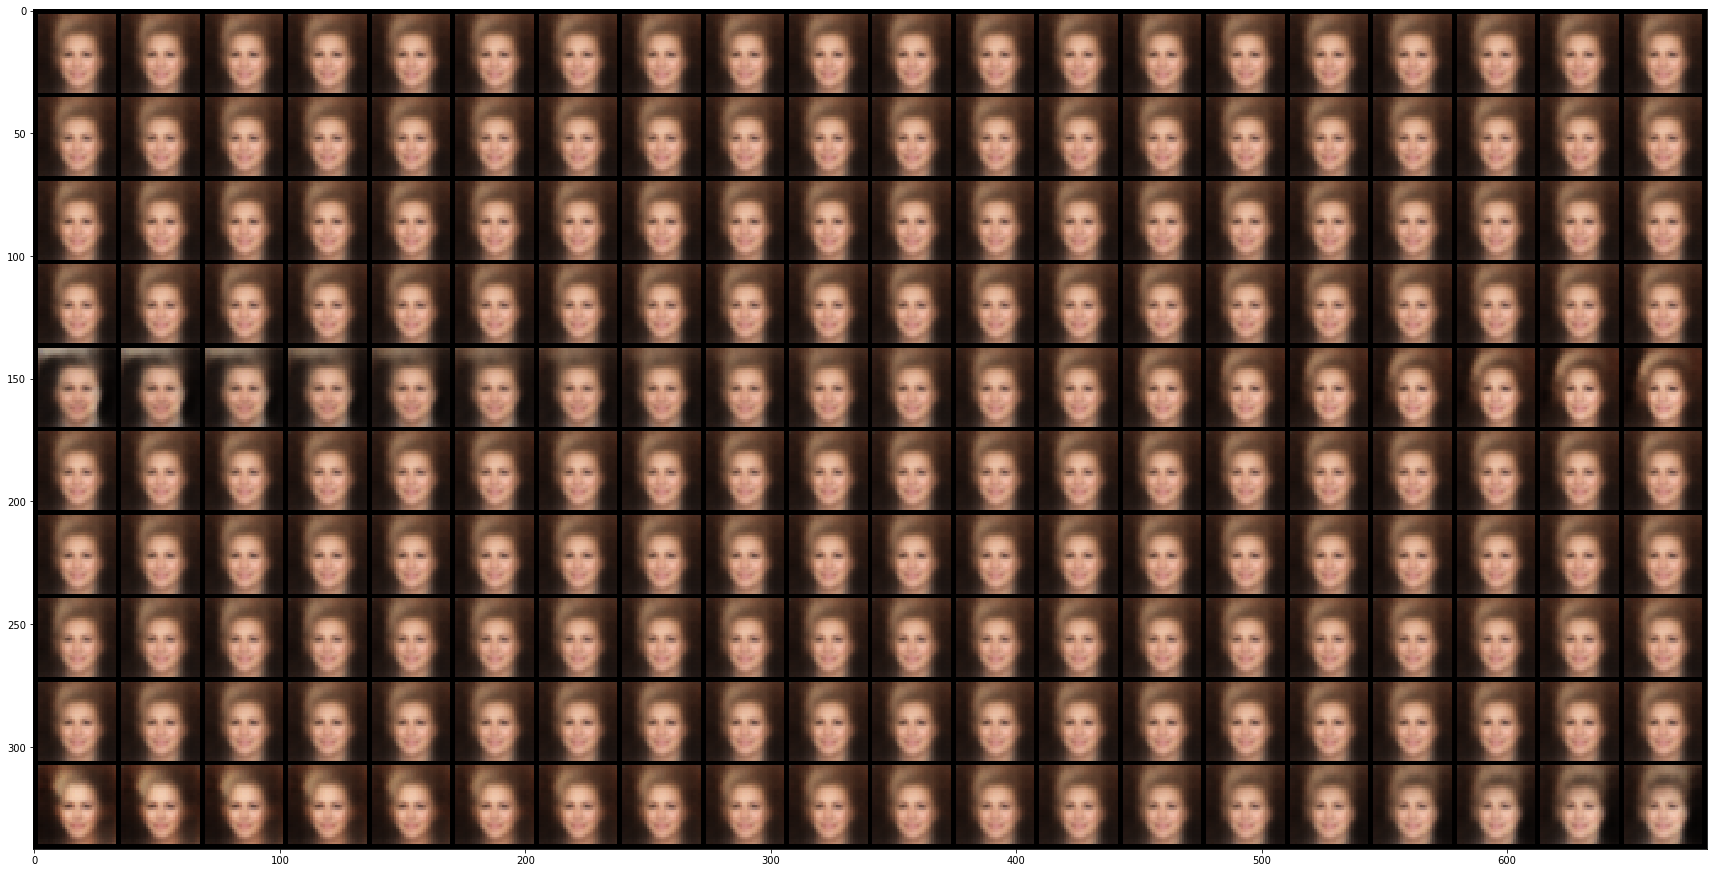

30
40


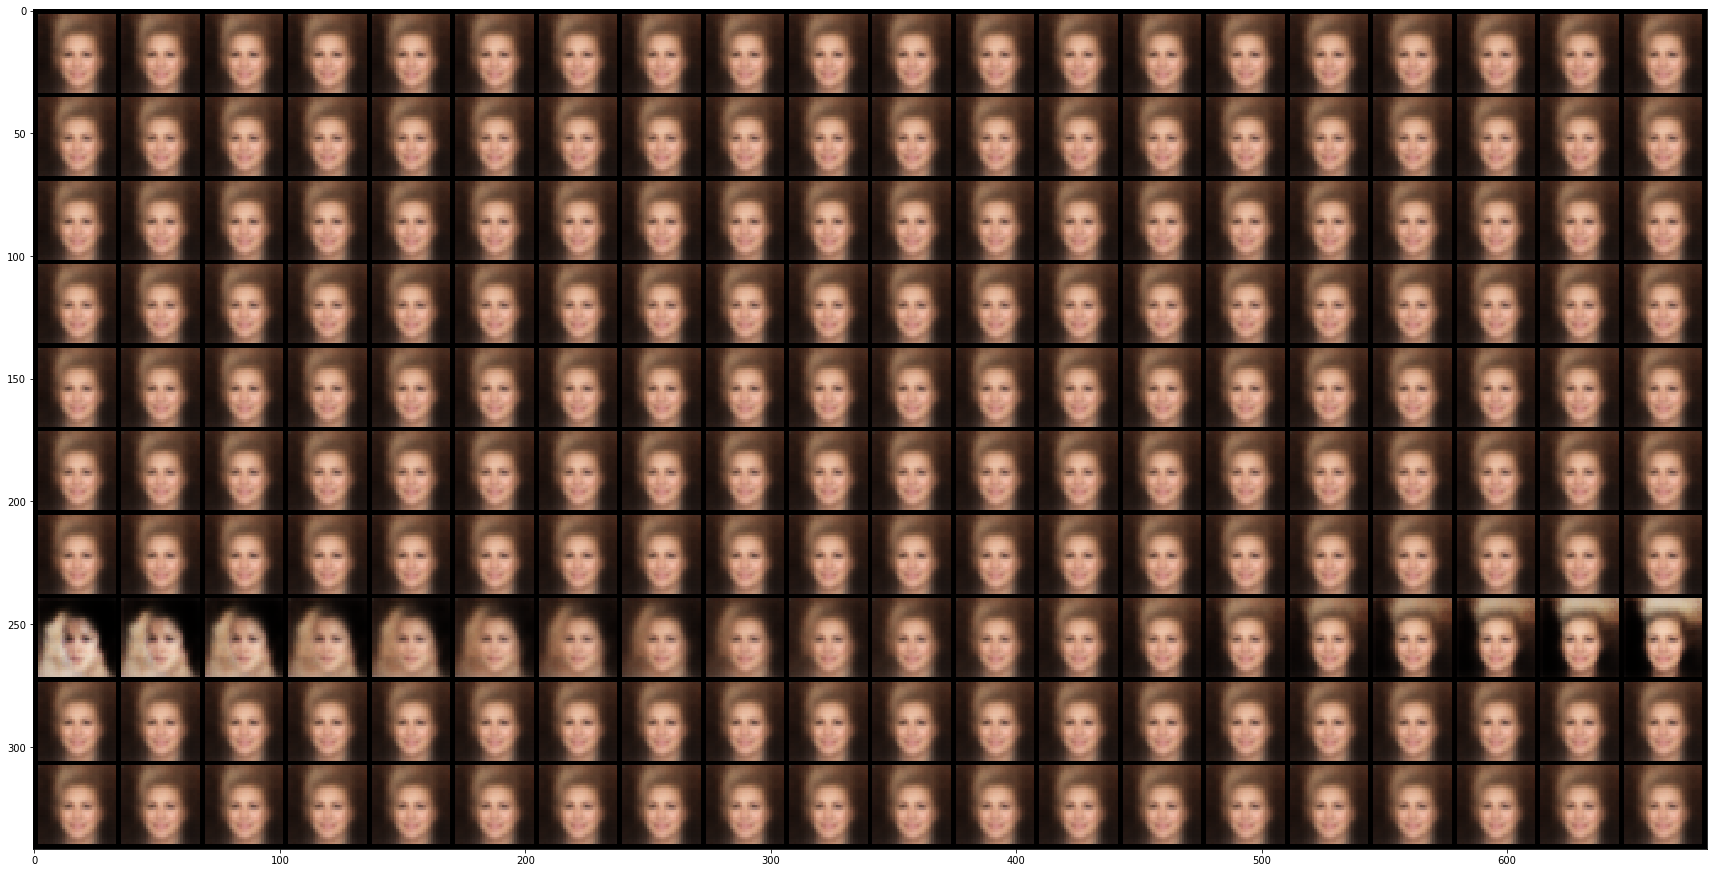

40
50


In [ ]:
#Code to reconstruct images, while keeping all the latent variables except the i'th (The row number is the variable that is changed)
#In the columns we see different reconstructions for the i'th latent variable in range (-4,4)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

model.eval()


b= 30
e = 30

rep1 = rep.clone().detach()
#rep = torch.zeros((1,64))

sampling = 20

for k in range(7):
    x = np.zeros((sampling * 10,3,32,32))
    b = k*10
    e = b+10

    if b == 60:
        e = 63
    
    print(b)
    print(e)
    for j in range(b, e):
        z = rep[0][j].item()
        for idx,i in enumerate(np.linspace(-4,4,sampling)):
            rep = torch.ones_like(rep)
            #rep = rep1.clone()
            rep[0][j] = i 

            out = model.decoder_f(rep)
            out = out.view(-1,256,2,2)
            out = model.decoder(out)
            out = out.cpu().detach()[0].numpy()
            x[(j-b)*sampling + idx] = out[:,::2,::2]

  
    x = np.interp(x, (-1,1), (0,1))
    x = torch.from_numpy(x)
    plt.figure(figsize=(10*3,30*3))
    x = torchvision.utils.make_grid(x, nrow= sampling)
    show(x)
    plt.show()